In [1]:
# import block
# some of these may not be needed
import numpy as np
from astropy.io import fits
import pdb
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib
from astropy.visualization import hist
from datetime import datetime
from pathlib import Path
import os
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D, Gaussian1D,Gaussian2D,Polynomial2D
from astropy.modeling import fitting
from astropy.stats import mad_std
from astropy.nddata import CCDData, StdDevUncertainty
from scipy import stats
from astropy import units as u
from photutils.aperture import CircularAperture,CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.table import Table
from astropy.coordinates import SkyCoord

from scipy.optimize import curve_fit

from imexam.imexamine import Imexamine

Ginga not installed, use other viewer, or no viewer


In [2]:
# import convenience plotting functions downloaded from 
# here: https://github.com/mwcraig/ccd-reduction-and-photometry-guide
phot_tutorial_dir = '/Users/gersbaka/Documents/Homework/Astro8060/ccd-reduction-and-photometry-guide/notebooks/'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

In [3]:
data_dir = '/Users/gersbaka/Documents/Homework/Astro8060/NoBackupImages/raw/'            # raw data directory
reduced_dir = '/Users/gersbaka/Documents/Homework/Astro8060/NoBackupImages/reduced/' # working directory

---

## Problem 1

Plot your standard star instrumental magnitudes from HW6 versus their airmass (or since you have many different standard stars taken at different airmass, plot the difference between the accepted magnitude and your instrumental magnitude versus airmass). Use one of the linear fitting routines in Python to do a least squares fit to find and plot the extinction coefficients at each filter. You can find the standard star magnitudes and colors in Landolt (1992).

---

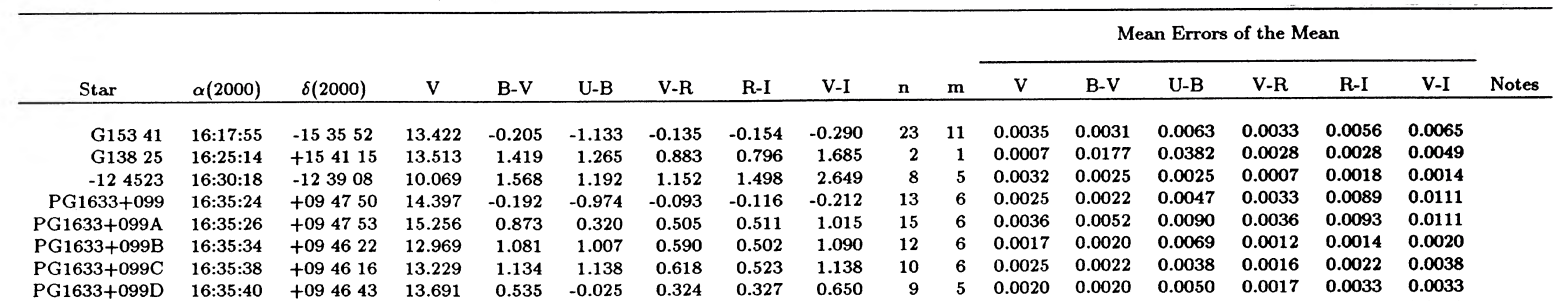

In [4]:
#Order: D,C,B,A,1 (Messed up elsewhere, this is the fastest fix)

# U, B, V, R, I
V   = np.array([14.397,15.256,12.969,13.229,13.691])
V   = np.flip(V)
B_V = np.array([-0.192,0.873,1.081,1.134,0.535])
B_V = np.flip(B_V)
U_B = np.array([-.964,0.320,1.007,1.138,-0.025])
U_B = np.flip(U_B)
V_R = np.array([-0.093,0.505,0.590,0.618,0.324])
V_R = np.flip(V_R)
R_I = np.array([-0.116,0.511,0.502,0.523,0.327])
R_I = np.flip(R_I)
V_I = np.array([-0.212,1.015,1.090,1.138,0.650])
V_I = np.flip(V_I)

B = B_V+V
U = U_B+B
I = V-V_I
R = R_I+I


Accepted_Magnitudes = np.array([U,B,V,R,I])
print(Accepted_Magnitudes)
#AcceAccepted_Magnitudes -> [filter,star#]

[[14.201 15.501 15.057 16.449 13.241]
 [14.226 14.363 14.05  16.129 14.205]
 [13.691 13.229 12.969 15.256 14.397]
 [13.368 12.614 12.381 14.752 14.493]
 [13.041 12.091 11.879 14.241 14.609]]


In [5]:
pg1633Files = ['a'+str(i).zfill(3)+'otzf.fits' for i in np.arange(81,93)]
pg1633Files.extend( ['a'+str(i).zfill(3)+'otzf.fits' for i in np.arange(130,140)]  )
pg1633Files.extend( ['a'+str(i).zfill(3)+'otzf.fits' for i in np.arange(202,212)]  )

pg1633fits = np.array([fits.open(reduced_dir+f) for f in pg1633Files])
pg1633data = [f[0].data for f in pg1633fits]

#Manually get all the airmasses for each image
pg1633Airmasses = [1.18]*9+[1.17]*3+[1.23]*1+[1.24]*9+[1.49]*2+[1.51]*2+[1.52]*2+[1.53]*4
pg1633Airmasses = np.array(pg1633Airmasses)

pg1633Filters = np.array([f[0].header['FILTER'] for f in pg1633fits])

print(len(pg1633Airmasses))
print(len(pg1633Files))

32
32


In [6]:
#Add airmasses to the fits headers

for i in range(len(pg1633fits)):
    pg1633fits[i][0].header['AIRMASS']=pg1633Airmasses[i]

In [7]:
print(pg1633Files)

['a081otzf.fits', 'a082otzf.fits', 'a083otzf.fits', 'a084otzf.fits', 'a085otzf.fits', 'a086otzf.fits', 'a087otzf.fits', 'a088otzf.fits', 'a089otzf.fits', 'a090otzf.fits', 'a091otzf.fits', 'a092otzf.fits', 'a130otzf.fits', 'a131otzf.fits', 'a132otzf.fits', 'a133otzf.fits', 'a134otzf.fits', 'a135otzf.fits', 'a136otzf.fits', 'a137otzf.fits', 'a138otzf.fits', 'a139otzf.fits', 'a202otzf.fits', 'a203otzf.fits', 'a204otzf.fits', 'a205otzf.fits', 'a206otzf.fits', 'a207otzf.fits', 'a208otzf.fits', 'a209otzf.fits', 'a210otzf.fits', 'a211otzf.fits']


In [8]:
#Get positions of all landolt stars in each frame (in order 1,A,B,C,D)
landoltPositions=[]
#081 - 086 : 6 frames
for i in range(6):
    landoltPositions.append([ [991,1050], [1047,1044], [1254,1222], [1366,1232], [1446,1183]])

#087 - 92 : 6 frames
for i in range(6):
    landoltPositions.append([ [987,1051], [1043,1045], [1250,1224], [1362,1233], [1442,1184]])
    
#130 - 139 : 10 frames
for i in range(10):
    landoltPositions.append([ [933,1044], [989,1038], [1196,1216], [1308,1226], [1388,1177]])

#202 - 211 : 10 frames
for i in range(10):
    landoltPositions.append([ [926,1037], [981,1031], [1188,1209], [1300,1219], [1381,1169]])

landoltPositions = np.array(landoltPositions)
print(len(landoltPositions))

32


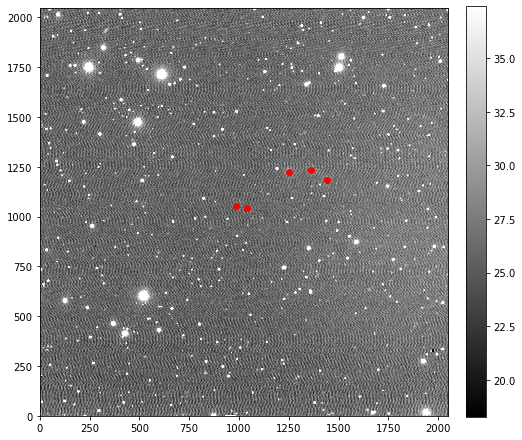

In [9]:
imgNum = 10

fig, ax = plt.subplots(1,1, figsize=(8,8))
show_image(pg1633data[imgNum],ax=ax,fig=fig,cmap='gray')

plt.scatter(landoltPositions[imgNum,:,0],landoltPositions[imgNum,:,1],color='r')

#ax.set_xlim([900,1500]) # use these to zoom in/out
#ax.set_ylim([800,1400])
plt.show()

a081otzf.fits


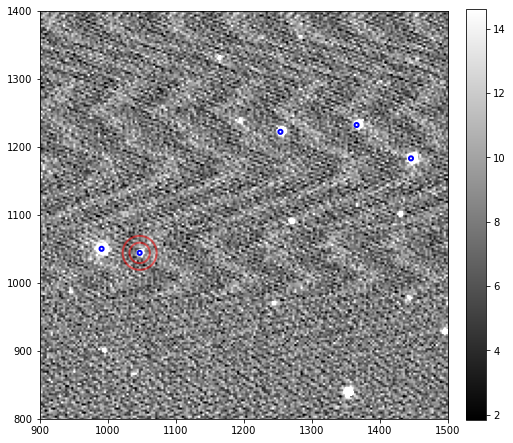

(32,)


In [10]:
#For each image, get the instrumental magnitudes
imag_star1 = []
imag_starA = []
imag_starB = []
imag_starC = []
imag_starD = []

mdif_star1 = []
mdif_starA = []
mdif_starB = []
mdif_starC = []
mdif_starD = []

for i in range(len(pg1633Files)):
    
    imgData = pg1633data[i]
    airmass = pg1633fits[i][0].header['AIRMASS']
    filter = pg1633fits[i][0].header['FILTER']
    starPos = landoltPositions[i]
    
    circles = CircularAperture(starPos,3)
    annulus = CircularAnnulus(starPos[1],15,25)
    
    
    if i==0:
        #Just show the first one
        print(pg1633Files[i])
        fig, ax = plt.subplots(1,1, figsize=(8,8))
        show_image(imgData,ax=ax,fig=fig,cmap='gray')

        [c.plot(color='blue',lw=2,alpha=1) for c in circles]
        annulus.plot(color='red',lw=2,alpha=.5)
        
        ax.set_xlim([900,1500]) # use these to zoom in/out
        ax.set_ylim([800,1400])
        plt.show()
    
    #Get the background
    bg_total = aperture_photometry(imgData,annulus)['aperture_sum'][0]
    bg = bg_total/annulus.area
    
    #Get the total signal
    tot = aperture_photometry(imgData,circles)['aperture_sum']
    area = circles[0].area #All circles have the same area
    
    imag1 = -2.5*np.log(tot[0]-area*bg) 
    imagA = -2.5*np.log(tot[1]-area*bg)
    imagB = -2.5*np.log(tot[2]-area*bg) 
    imagC = -2.5*np.log(tot[3]-area*bg)
    imagD = -2.5*np.log(tot[4]-area*bg)
    
    imag_star1.append(imag1)
    imag_starA.append(imagA)
    imag_starB.append(imagB)
    imag_starC.append(imagC)
    imag_starD.append(imagD)
    
    
    if filter=='U':
        mdif_star1.append(Accepted_Magnitudes[0,0]-imag1)
        mdif_starA.append(Accepted_Magnitudes[0,1]-imagA)
        mdif_starB.append(Accepted_Magnitudes[0,2]-imagB)
        mdif_starC.append(Accepted_Magnitudes[0,3]-imagC)
        mdif_starD.append(Accepted_Magnitudes[0,4]-imagD)
    if filter=='V':
        mdif_star1.append(Accepted_Magnitudes[1,0]-imag1)
        mdif_starA.append(Accepted_Magnitudes[1,1]-imagA)
        mdif_starB.append(Accepted_Magnitudes[1,2]-imagB)
        mdif_starC.append(Accepted_Magnitudes[1,3]-imagC)
        mdif_starD.append(Accepted_Magnitudes[1,4]-imagD)
    if filter=='B':
        mdif_star1.append(Accepted_Magnitudes[2,0]-imag1)
        mdif_starA.append(Accepted_Magnitudes[2,1]-imagA)
        mdif_starB.append(Accepted_Magnitudes[2,2]-imagB)
        mdif_starC.append(Accepted_Magnitudes[2,3]-imagC)
        mdif_starD.append(Accepted_Magnitudes[2,4]-imagD)
    if filter=='R':
        mdif_star1.append(Accepted_Magnitudes[3,0]-imag1)
        mdif_starA.append(Accepted_Magnitudes[3,1]-imagA)
        mdif_starB.append(Accepted_Magnitudes[3,2]-imagB)
        mdif_starC.append(Accepted_Magnitudes[3,3]-imagC)
        mdif_starD.append(Accepted_Magnitudes[3,4]-imagD)
    if filter=='I':
        mdif_star1.append(Accepted_Magnitudes[4,0]-imag1)
        mdif_starA.append(Accepted_Magnitudes[4,1]-imagA)
        mdif_starB.append(Accepted_Magnitudes[4,2]-imagB)
        mdif_starC.append(Accepted_Magnitudes[4,3]-imagC)
        mdif_starD.append(Accepted_Magnitudes[4,4]-imagD)
    if filter=='Ha':
        mdif_star1.append(0)
        mdif_starA.append(0)
        mdif_starB.append(0)
        mdif_starC.append(0)
        mdif_starD.append(0)
    
    
imag_star1 = np.array(imag_star1)
imag_starA = np.array(imag_starA)
imag_starB = np.array(imag_starB)
imag_starC = np.array(imag_starC)
imag_starD = np.array(imag_starD)

mdif_star1 = np.array(mdif_star1)
mdif_starA = np.array(mdif_starA)
mdif_starB = np.array(mdif_starB)
mdif_starC = np.array(mdif_starC)
mdif_starD = np.array(mdif_starD)
print(mdif_starA.shape)

extinction in U filter: k=4.18330511266217


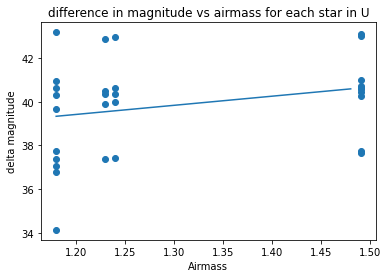

extinction in B filter: k=1.2094123043806653


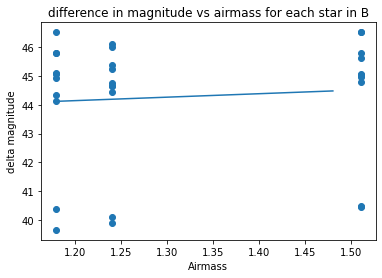

extinction in V filter: k=1.8659195620625115


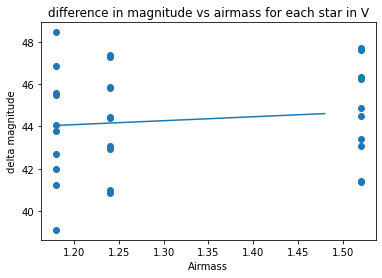

extinction in R filter: k=2.1891684659222514


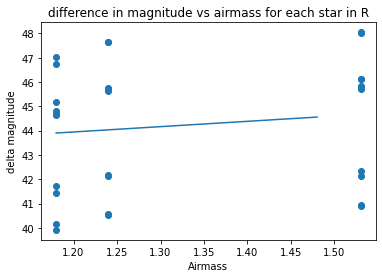

extinction in I filter: k=2.1471849880435303


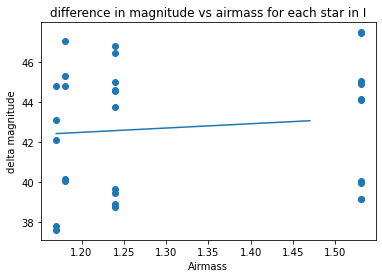

Constant offset of: 40.03165202642556


In [61]:
#Plot Difference in magnitude vs airmass (For each filter)

extCoef = []
const = []
for f in ['U','B','V','R','I']:
    
    imgsIndex = [i for i in range(len(pg1633fits)) if pg1633fits[i][0].header['FILTER']==f]
    
    pts = []
    for i in imgsIndex:
        a = pg1633Airmasses[i]
        pts.append((mdif_star1[i],a))
        pts.append((mdif_starA[i],a))
        pts.append((mdif_starB[i],a))
        pts.append((mdif_starC[i],a))
        pts.append((mdif_starD[i],a))
    pts = np.array(pts)

    #Linear fitting
    #M_A = m + k*X
    #M_A-m = k*X 
    
    t = np.polyfit(pts[:,1],pts[:,0],1)
    #def ext(X,k):
    #    return k*X
    
    #t = curve_fit(ext,pts[:,1],pts[:,0])
    xval = np.arange(min(pts[:,1]),max(pts[:,1]),.1)
    yval = t[0]*xval+t[1]
    extCoef.append(t[0])
    const.append(t[1])
    
    print('extinction in {} filter: k={}'.format(f,t[0]))
    
    #Plot the difference in mags vs airmass for each star
    fig = plt.figure(figsize=(6,4))
    plt.scatter(pts[:,1],pts[:,0])
    plt.plot(xval,yval)
    plt.title('difference in magnitude vs airmass for each star in '+f,)
    plt.ylabel('delta magnitude')
    plt.xlabel('Airmass')
    plt.show()
    
print('Constant offset of:',np.average(const))
offset = np.average(const)

### Discussion

Well, these results are extremely underwhelming and I'm almost POSITIVE I did something wrong. I had been working on this problem for the majority of my time on this asignment, but I still feel very dissatisfied with the results.

To explain myself a bit:
- IMPORTANT: I originally mislabeled the stars in reverse order. So the star in my code labeled star1 is actually starD in the Landolt paper. By the time I caught my mistake, I was already way too deep and instead flipped my known magnitudes, as these were much easier to swap around.
- My first assumption that I used in this problem relates to the positions of the Landolt stars in my images. I made the decision that images taken close together in time (i.e sequential photos with less than a minute between frames) show VERY little motion of the frame on the sky. Because of this, I used the positions of these stars, which I grabbed from DS9, from the middle frame of the series of consecutive images. i.e if a set of 9 images where sequential, I used the same star positions taken from frame 5 for all frames. This idea cut down on some of the monotonous work, but likely results in small errors.
- The airmasses were taken from the log file. While there are airmasses in the fits files, they are FAR too large to be realistic (some even around 4).

From these assumptions, I was able to use the same process as last homework to derive instrumental magnitudes. Nothing strange yet. Next, based on info from the Landolt paper, I found the actual magnitudes of all of these stars and got a difference between the instrumental magnitudes and actual. From here, I was able to plot the difference between airmass and magnitude difference.

Now, the unsatisfying part, these results don't make much sense. The overall spread between stars is *okay*, but the variation in 1 star show drastic differences for small changes of airmass. Despite these plots looking rather horendous, I did follow through and find extinction corrections for each band. These values however, are SIGNIFICANTLY different from my peers, so I know I've somehow made a mistake, I'm just not sure where...


---
## Problem 2

After extinction correcting your standard stars to zero airmasses (i.e., you’re correcting to the top of the atmosphere), make a plot of the difference between real magnitudes and instrumental magnitudes using your standard stars as a function of V−R color and B−V color. Fit a linear relation to this trend. The fit gives you your instrumental zero points and the first order color term which let you transform your instrumental photometry to the standard system. Tabulate the instrumental zero point and first order color terms for each band in a neat, digestible way

---

In [77]:

#Exctinction correction
for i in range(len(pg1633Files)):
    filt = pg1633Filters[i]
    
    k = 0
    if filt=='U':
        k = extCoef[0]
    if filt=='V':
        k = extCoef[1]
    if filt=='B':
        k = extCoef[2]
    if filt=='R':
        k = extCoef[3]
    if filt=='I':
        k = extCoef[4]
        
    #M_A = m + k*X
    #m = M_A - kX
    imag_star1[i] +=pg1633Airmasses[i]*k + offset
    imag_starA[i] +=pg1633Airmasses[i]*k + offset
    imag_starB[i] +=pg1633Airmasses[i]*k + offset
    imag_starC[i] +=pg1633Airmasses[i]*k + offset
    imag_starD[i] +=pg1633Airmasses[i]*k + offset
 

Color coefficients for U: [-1.15979872 -4.83942337]


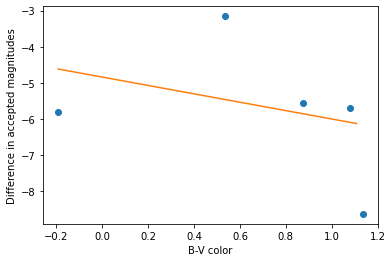

Color coefficients for B: [-1.06793121  3.22277136]


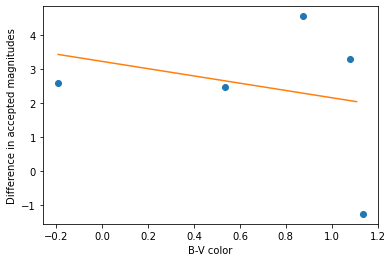

Color coefficients for V: [-1.20142865  2.81550416]


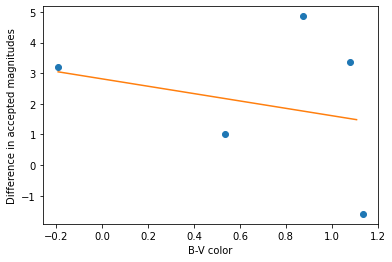

Color coefficients for R: [-1.12806312  2.05983599]


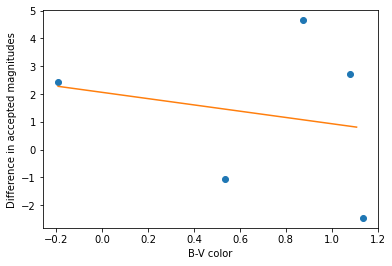

Color coefficients for I: [-0.93647328  0.51327371]


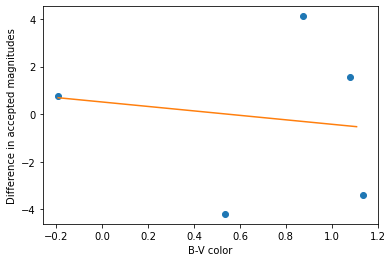

In [110]:
#Real-Obs vs B-V
#V-V_0 = C_0,v + C_1,v(B_0-V_0)

colorCoefFilter = []
for f in ['U','B','V','R','I']:
    difs = []
    bvs = [] 

    index = np.where(pg1633Filters==f)[0]

    for i in index:
        imags = np.array([ imag_star1[i],
                           imag_starA[i],
                           imag_starB[i],
                           imag_starC[i],
                           imag_starD[i] ])

        if f=='U':
            imagDif = U - imags
        if f=='B':
            imagDif = B - imags
        if f=='V':
            imagDif = V - imags
        if f=='R':
            imagDif = R - imags
        if f=='I':
            imagDif = I - imags
        
        difs.extend(imagDif)
        bvs.extend(B_V)

    plt.plot(B_V,imagDif,'o')
    
    #Linear regression
    t = np.polyfit(bvs,difs,1)
    colorTerms = t
    colorCoefFilter.append(colorTerms)
    print('Color coefficients for '+f+':',colorTerms)
    xvals = np.arange(min(bvs),max(bvs),0.1)
    yvals = xvals*t[0]+t[1]
    plt.plot(xvals,yvals)
    plt.xlabel('B-V color')
    plt.ylabel('Difference in accepted magnitudes')
    plt.show()





| Band | C_0 | C_1 |
|------|-----|------|
| U | -1.1597 | -4.8394 |
| V | -1.0679 | 3.2227 |
| B | -1.2014 | 2.8155 |
| R | -1.1280 | 2.0598 |
| I | -0.9364 | 0.5132 |



### Discussion

Similar to question 2, I am also quite dissatisfied with my results here.

Following similar steps as question 1, I derived my values from the corrected magnitudes found from question 1 (so there is likely error being carried through). Like last time, the linear regression was a total mess, with the spread of points all over the place. These trend likes look laughable. I struggled to make these plots look any better, so I just tried to move on, and hope I could figure it out later. 

---

## Problem 3

Using the extinction terms and color terms derived for the imaging dataset previously, do photometry on the stars in NGC6823 and make a color magnitude diagram of this open cluster and compare it to a published one. Either V vs. B−V or R vs. R−I are the most common ones you might find, but there may be others. Assess in a paragraph semi-quantitatively how well does your data agree with published data? Note that your data may be affected by interstellar extinction, so you may need to deredden your data to better match the published CMD, if the published CMD has been corrected already. Use a paper such as Cardelli, Clayton, & Mathis (1989) to do the dereddening

---

In [70]:
#Again, more problems in the previous parts, corrections are not 
#implemented, but the code to do so is here

#Grab B and V files
ngcFiles = ['a159otzf.fits','a160otzf.fits']
ngcFits = [fits.open(reduced_dir+f) for f in ngcFiles]
ngcData = [f[0].data for f in ngcFits]

ngcAirmass = [1.09,1.09]
ngcFilters = ['V','B']


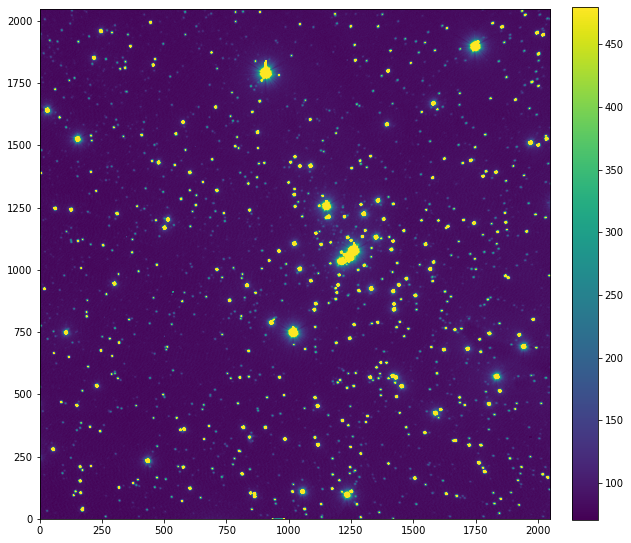

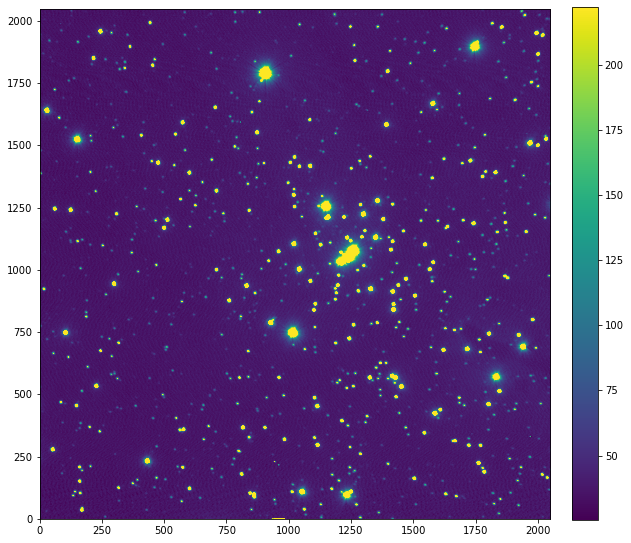

In [34]:
show_image(ngcData[0])
show_image(ngcData[1])

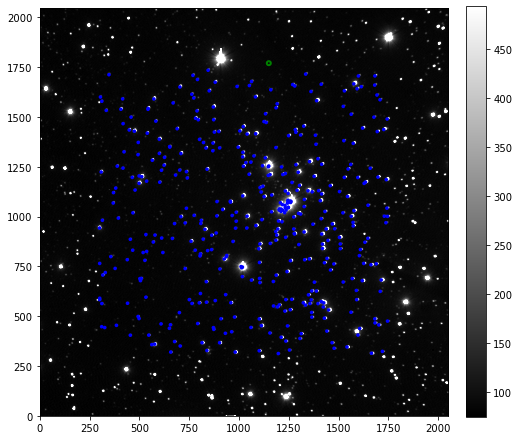

In [54]:
#Locate in one image, use in the other (taken within minutes, sky hasn't shifted much)
mean, median, std = sigma_clipped_stats(ngcData[0],sigma=3)
daofind = DAOStarFinder(fwhm=4,threshold=20*std)
sources = daofind(ngcData[0][300:-300,300:-300]) #Move away from edge!
positions = [(s['xcentroid']+300,s['ycentroid']+300) for s in sources]

circs = CircularAperture(positions,r=4)


#Need a dark area of the sky, use a circular aperture here:
bgCirc = CircularAperture((1150,1770),r=10)

fig, ax = plt.subplots(1,1, figsize=(8,8))
show_image(ngcData[0],ax=ax,fig=fig,cmap='gray')

circs.plot(color='blue',lw=2,alpha=1)
bgCirc.plot(color='green',lw=2,alpha=1)

#Uncomment these to see the dark region used for background
#ax.set_ylim([1750,1800]) # use these to zoom in/out
#ax.set_xlim([1100,1200])
plt.show()


In [100]:
#For V band

ignoreIndex = []

#Background
Vbg_total = aperture_photometry(ngcData[0],bgCirc)['aperture_sum']
Vbg = Vbg_total[0]/bgCirc.area #Background per pixel

#Get the total signal
Vtot = aperture_photometry(ngcData[0],circs)['aperture_sum']
area = circs[0].area #All circles have the same area
    
#Ensure stars aren't saturated!
for i in range(len(positions)):
    if Vtot[i] > 0.8*65536*area:
        #Likely saturated, ignore index
        ignoreIndex.append(i)

Vimag = -2.5*np.log(Vtot-area*Vbg)
VcorrectedImag = Vimag + ngcAirmass[0]*extCoef[2] + offset #Correct for extinction


print(VcorrectedImag[0:10])#Just to make sure

   aperture_sum   
------------------
 19.93707977363184
13.118378907260205
16.324876289906648
 10.88356420095839
18.556312588899978
13.981771949453414
13.065802437178153
 18.60040681824253
17.943664060682206
12.399614128546979


In [101]:
#Background
Bbg_total = aperture_photometry(ngcData[1],bgCirc)['aperture_sum']
Bbg = Bbg_total[0]/bgCirc.area #Background per pixel

#Get the total signal
Btot = aperture_photometry(ngcData[1],circs)['aperture_sum']
area = circs[0].area #All circles have the same area
    
#Ensure stars aren't saturated!
for i in range(len(positions)):
    if Btot[i] > 0.8*65536*area and i not in ignoreIndex:
        #Likely saturated, ignore index
        ignoreIndex.append(i)

Bimag = -2.5*np.log(Btot-area*Bbg)
BcorrectedImag = Bimag + ngcAirmass[1]*extCoef[2] + offset #Correct for extinction

print(BcorrectedImag[0:10])#Just to make sure

   aperture_sum   
------------------
23.816927244973154
 16.01099442277812
19.482363239920943
14.682039844756812
21.568966276863698
16.861666680290664
 17.54791733288463
22.653688984783077
21.142418200365412
14.689050085301659


/var/folders/bb/_0rqpxpd2cl3kcsqv4vkt18h0000gq/T/ipykernel_97099/3043904662.py:15: RuntimeWarning: invalid value encountered in log
  Bimag = -2.5*np.log(Btot-area*Bbg)


In [113]:
#Remove members that are saturated
VcorrectedImag = np.delete(VcorrectedImag,ignoreIndex)
BcorrectedImag = np.delete(BcorrectedImag,ignoreIndex)

In [114]:
#Need to correct for color!
ngcB_V = BcorrectedImag - VcorrectedImag

for i in range(len(ngcB_V)):
    c = ngcB_V[i]
    VcorrectedImag[i] += colorCoefFilter[2][0]*c +colorCoefFilter[2][1]
    BcorrectedImag[i] += colorCoefFilter[1][0]*c +colorCoefFilter[1][1] 


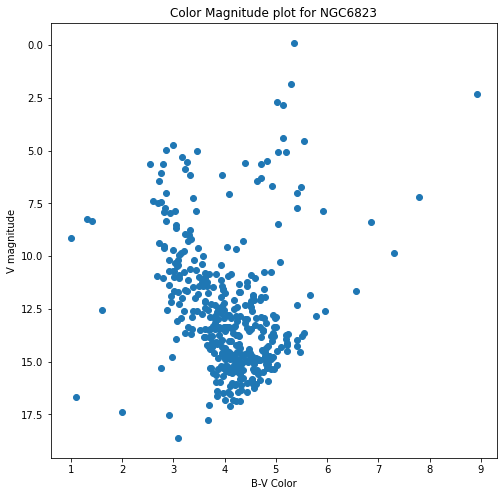

In [115]:
plt.figure(figsize=(8,8))
plt.scatter(ngcB_V,VcorrectedImag)
plt.title('Color Magnitude plot for NGC6823')
plt.ylabel('V magnitude')
plt.xlabel('B-V Color')
plt.gca().invert_yaxis()

Image from:
Guetter, Harry H. "Photometric studies of stars in the young open cluster NGC 6823." The Astronomical Journal 103 (1992): 197-203.
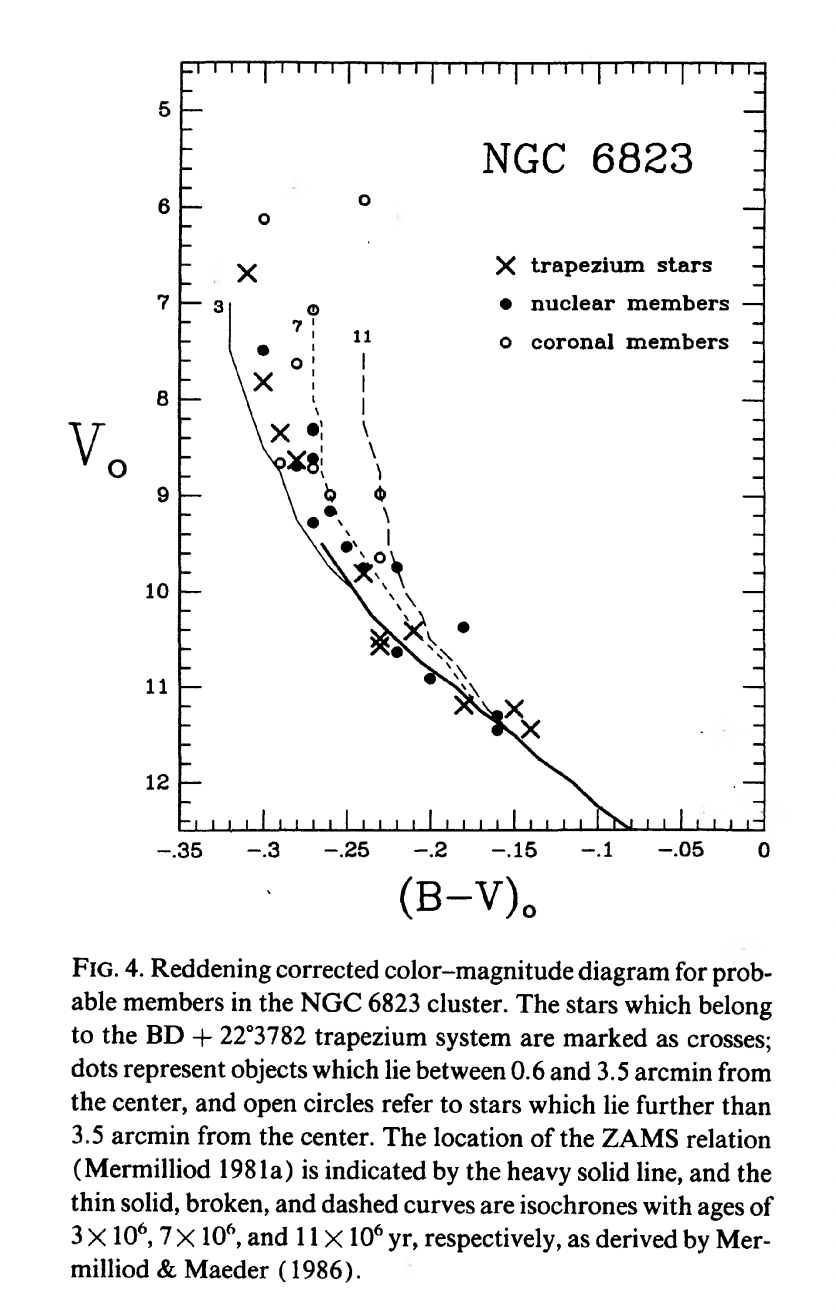

### Discussion

And the culmination of the work is... not great. Firstly the scale, while Guetter measured stars from magnitude 6 down to magnitude 11.5, my data goes from nearly 0 to >18 ! Thats a monsterous difference! Likewise with the x-axis, my B-V color indicies mostly fall between 3 and 6, and Guetter has all negative values! Something must have gone drastically wrong!

While the shape of an main sequence is sort of there, the overall structure of it is weak with only a short linear trend line from magnitude 18 to about magnitude 10. Contrast that with that which Guetter found, where the stars were showing a similar linear trend, but from 11 to about 9. I also discovered that there likely are stars V>5 and B-V<3 within my dataset, but most of them were scrapped due to saturation of the images. If I was more thorough, I could have used the shorter exposure times to fill out that space better.

## Overall Discussion

While I do think I could have done a lot better on this asignment, I didn't put in the required amount of time and had to short myself and the asignment more than I wanted. Another aspect that could have gone better is either more collaboration with classmates or attending more office hours. 
This was definitely a lot harder of an assignment than I was expecting it to be